# 5. PyCSI Example Use

The following example shows how to use PyCSI to get data from a model and create a plot.

## Statement

The models in the [5_Example_use_models](../resources/example_model/5_Example_use_models) folder represent the different model updates in the Design Development phase of a building. The following is a summary of the modelling process:

1. **Model 1**

  * Modeled SFRS framing, gravity framing and concrete over metal deck elements.
  * Model considers only the distributed mass over the slab area

2. **Model 2**

  * Added mass at the perimeter framing to represent the self-weight of the exterior walls.

3. **Model 3**

  * Per architectural updates, the mass of Level 3 and the Roof level got increased in order to consider heavy equipment located at this levels.
  * MEP slab openings included in the model

4. **Model 4**

  * Building shape was updated to an L-shape.
  * Slab openings for stairs and elevator shafts included in the model

The objective is to make a comparison of the Maximum Story Drifts at each step of the design process. To achieve this, PyCSI is used to open each model, get the drifts and plot the results.

## Example Code

The following code achieves the objective set in the example statement.

### 1. Initial Setup

The following code imports the required packages, including PyCSI. Additionally, it creates the instance of the ETABS model class and creates a new window.

In [1]:
# Package imports

import os
import math

try:
    # PyCSI import
    import pyCSI
    
except ImportError:    
    ###################################################################
    # The following lines are only necessary for these tutorials
    from pathlib import Path
    pyCSI_dir = str(Path(os.getcwd()).parents[2])
    os.chdir(pyCSI_dir)
    import pyCSI
    ###################################################################

from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

from pyCSI import ETABSModel # PyCSI ETABS model class
from pyCSI import LengthUnit # PyCSI Length unit enumerator

model = ETABSModel(version=19)
model.get_model(active_model=False)


####################################################################
DEGENKOLB ENGINEERS
You are using PyCSI v0.1
Questions or comments contact Luis Pancardo
####################################################################



### 2. Get the model names

To open all of the available models using PyCSI, the following cell gets a list of all the models inside the from the [5_Example_use_models](../resources/example_model/5_Example_use_models) folder.

In [2]:
# Example model location
models_path = pyCSI_dir + '/docs/tutorials/resources/example_model/5_Example_use_models'

# Get a list of all the files in the folder
files = os.listdir(models_path)

# Create a list with all the files that end with *.EDB (ETABS files)
model_files = [models_path + '/' + file for file in files if file.endswith(".EDB")]
print(f'Found {len(model_files)} ETABS model')
display(model_files)


Found 4 ETABS model


['c:\\Users\\lpancardo\\OneDrive - Degenkolb Engineers\\Documents\\Projects\\Local Working\\12. Coders Group\\PyCSI/docs/tutorials/resources/example_model/5_Example_use_models/model_1.EDB',
 'c:\\Users\\lpancardo\\OneDrive - Degenkolb Engineers\\Documents\\Projects\\Local Working\\12. Coders Group\\PyCSI/docs/tutorials/resources/example_model/5_Example_use_models/model_2.EDB',
 'c:\\Users\\lpancardo\\OneDrive - Degenkolb Engineers\\Documents\\Projects\\Local Working\\12. Coders Group\\PyCSI/docs/tutorials/resources/example_model/5_Example_use_models/model_3.EDB',
 'c:\\Users\\lpancardo\\OneDrive - Degenkolb Engineers\\Documents\\Projects\\Local Working\\12. Coders Group\\PyCSI/docs/tutorials/resources/example_model/5_Example_use_models/model_4.EDB']

### 3.  Initialize the plot

In this example we are using matplotlib to created the maximum drift plots. For reference of matplotlib methods and properties se their [documentation](https://matplotlib.org/stable/api/matplotlib_configuration_api.html)

The following code will create the plot figure. It starts as an empty plot and data will be added for each model.

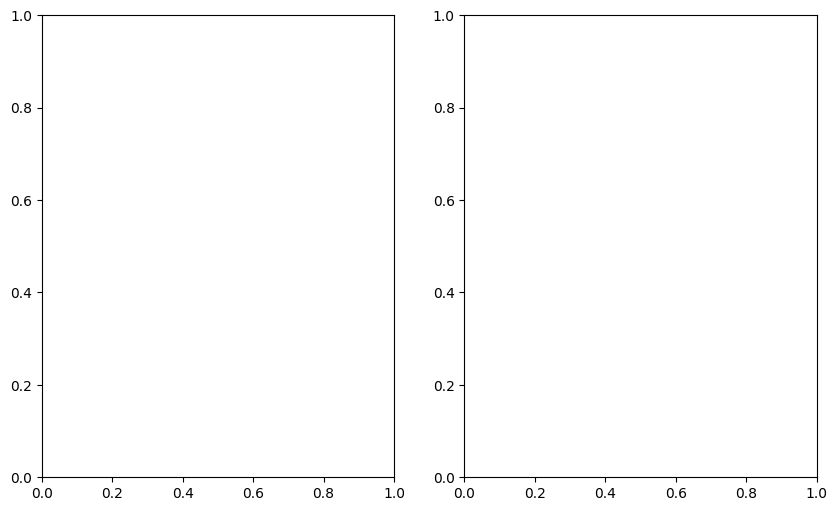

In [3]:
# Initialize plot figure
plt.figure(figsize=(10, 6))
drift_plot = plt.gcf()

# Create 2 subplots, one for each analysis direction
x_plot = plt.subplot(121)
y_plot = plt.subplot(122)

# Make a list with the plots in each direction
plots = [x_plot, y_plot]

### 4. Open the ETABS models and get the required data

PyCSI is used to open each of the models found in the example folder. For each model the following is done:

2. Open the existing file in the created window.
3. Make sure the model is unlocked to make changes.
4. Set the display length units to feet.
5. Set the load cases "DXE-Drift" and "DYE-Drift" as the only load cases to run.
6. Run the analysis.
7. Get story elevations from story definitions table
8. For each load case 'DXE-Drift' and 'DYE-Drift':
   
   1. Set tables property to only return data for corresponding load case.
   2. Get drifts from story drifts table.
   3. Plot data into corresponding plot
   
9. Unlock the model to delete analysis results

In [4]:
# Function definition to calculate the story elevations
def reverse_cumsum(data: pd.Series) -> pd.Series:
    '''Returns a DataFrame containing the cumulative sum of a
    specified column in reverse order'''

    cumulative_sum = data.iloc[::-1].cumsum()
    return cumulative_sum[::-1]

# Change visible property to false to hide the window
model.visible = True

# Load cases of interest
load_cases = ['DXE-Drift', 'DYE-Drift']

# Direction of analysis
directions = ['X', 'Y']

# Store maximum drift for later use
max_drift = 0

# Loop through the models
for i, file in enumerate(model_files):

    # Open the model
    model.file.open_file(file)

    # Make sure the model is unlocked to make changes.
    model.lock = False

    # Set force units to KIPS
    model.length_unit = LengthUnit.FT

    # Set DX and DY to run
    model.analysis.set_load_cases_to_run(False) # Set all load cases to Do not Run
    model.analysis.set_load_cases_to_run(True, load_cases)

    # Run analysis
    model.analysis.run_analysis()

    # Get story elevations
    story_definitions = model.tables.get_table_dataframe('Story Definitions')
    
    # Reverse cumulative sum of the Height column to calculate the story elevations.
    story_definitions['Elevation'] = reverse_cumsum(story_definitions['Height'])
    
    # Add the value zero for the elevation of the base
    story_elevations = pd.concat([story_definitions['Elevation'], pd.Series([0])])
    
    # Return no data from load combinations
    model.tables.load_combos = None 

    for load_case, direction, plot in zip(load_cases, directions, plots):
        
        print(f'Getting data for {direction} Direction')
        
        # To avoid manually filtering for each load case, 
        # specify to only get results for the corresponding load case
        model.tables.load_cases = [load_case] 
        
        # Get story drifts data
        print('Getting drifts table')
        drifts_table = model.tables.get_table_dataframe('Story Drifts')

        # Filter table for drifts only in the direction of analysis
        drifts_table = drifts_table[drifts_table['Direction'] == direction]
        
        # Take the Drift column and add the value zero for the drift at the base
        drifts = pd.concat([drifts_table['Drift'], pd.Series([0])])
        
        # Get maximum drift
        max_drift = max(drifts.max(), max_drift)
        
        # Plot the data in corresponding plot
        label = f'Model {i+1} - {direction} Drift'
        plot.plot(drifts, story_elevations, label=label)
        print('Data added to plot')

    # Unlock model to delete analysis results
    model.lock = False
    print(f'Finished with model {model.get_file_name()}', end='\n\n')
    
    

Successfully connected to model_1.EDB
Running analysis...
Analysis finished!
Getting data for X Direction
Getting drifts table
Data added to plot
Getting data for Y Direction
Getting drifts table
Data added to plot
Finished with model model_1.EDB

Successfully connected to model_2.EDB
Running analysis...
Analysis finished!
Getting data for X Direction
Getting drifts table
Data added to plot
Getting data for Y Direction
Getting drifts table
Data added to plot
Finished with model model_2.EDB

Successfully connected to model_3.EDB
Running analysis...
Analysis finished!
Getting data for X Direction
Getting drifts table
Data added to plot
Getting data for Y Direction
Getting drifts table
Data added to plot
Finished with model model_3.EDB

Successfully connected to model_4.EDB
Running analysis...
Analysis finished!
Getting data for X Direction
Getting drifts table
Data added to plot
Getting data for Y Direction
Getting drifts table
Data added to plot
Finished with model model_4.EDB



### 5. Available Data

The following is a sample of the data from the last analyzed model

In [5]:
# Story Definitions
print('Story Definitions Table')
display(story_definitions)

# Story Drifts
print('\n\nStory Drifts Table')
display(drifts_table)


Story Definitions Table


,Tower,Story,Height,IsMaster,SimilarTo,IsSpliced,Color,GUID,Elevation
0,T1,Roof,17,Yes,None,No,Magenta,c905fc00-3ae9-4589-84ca-6529ed1b09bd,66
1,T1,Level 3,17,Yes,None,No,Yellow,e2d076eb-9522-4ede-aa35-1e6ed9554c60,49
2,T1,Level 2,17,No,Level 3,No,Gray8Dark,001e8d87-6602-4045-b7df-5141eefa96d4,32
3,T1,Level 1,15,No,Level 3,No,Blue,95581b41-4c60-498d-b1ea-e56b05a3ee73,15




Story Drifts Table


,Story,OutputCase,CaseType,StepType,Direction,Drift,Label,X,Y,Z
1,Roof,DYE-Drift,LinRespSpec,Max,Y,0.009275,69,-0.5,90.5,66
3,Level 3,DYE-Drift,LinRespSpec,Max,Y,0.012301,69,-0.5,90.5,49
5,Level 2,DYE-Drift,LinRespSpec,Max,Y,0.015760,69,-0.5,90.5,32
7,Level 1,DYE-Drift,LinRespSpec,Max,Y,0.019700,4,0.0,90.0,15


### 5. Customize plots

Define titles and labels for each plot. Finally save the plot to an image.

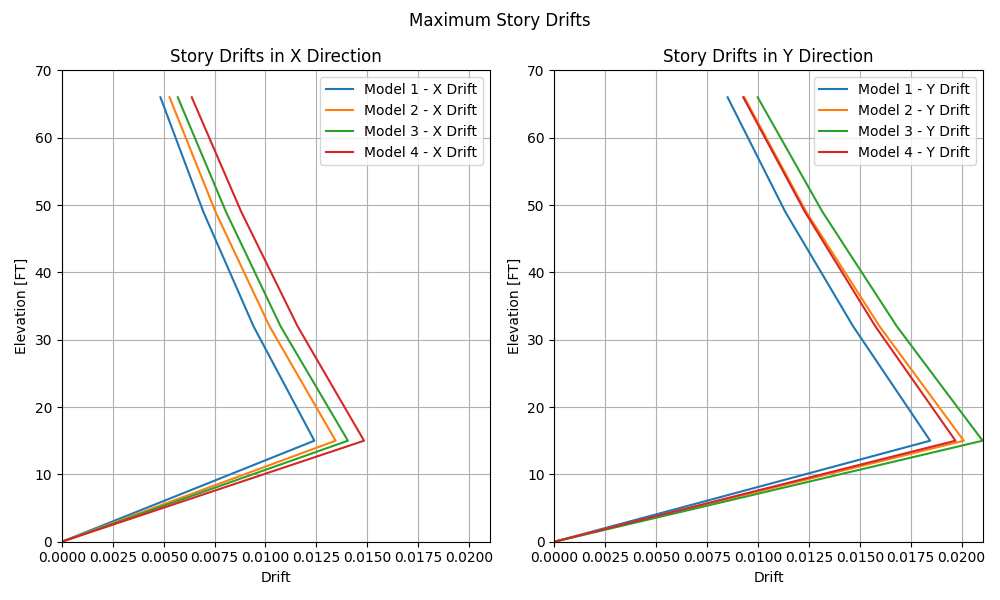

In [6]:
# Set figure title
drift_plot.suptitle('Maximum Story Drifts')

# Set title and labels for each plot
for direction, plot in zip(directions, plots):
    # Set title for each plot
    plot.set_title(f'Story Drifts in {direction} Direction')
    
    # Set X axis labels
    plot.set_xlabel('Drift')
    
    # Set X axis limits
    xmin = 0
    xmax = math.ceil(max_drift*100)/100
    plot.set_xlim(xmin, max_drift)
    
    # Set Y axis label
    # Use .length_unit to display the elevation units
    plot.set_ylabel(f'Elevation [{model.length_unit}]')
    
    # Set X axis limits
    ymin = story_elevations.min()
    ymax = math.ceil(story_elevations.max()/10)*10
    plot.set_ylim(ymin, ymax)
    
    # Show legend on each plot
    plot.legend()
    
    # Show grid
    plot.grid(True)
    
# Stretch plot to use all available space in figure
drift_plot.tight_layout()

# Finally save the plot result
image_path = 'docs/images/tutorials/drift_plot.png'
drift_plot.savefig(image_path)

# Show final plot
Image(image_path)

### Close the model

Finally, to close a model use the .`close_application([save_model])` method.

In [7]:
# Set save_model to True to save before closing, default is True
print('Closing model')
model.close_application(save_model=False)

Closing model


## Next -> [Troubleshooting & FAQs](6_Troubleshooting_and_FAQs.ipynb)

**REMEMBER to shut down the Kernel before leaving**

Click `Kernel -> Shut Down Kernel`

### Contact

For questions or comments please reach out to:

* Luis Pancardo: [lpancardo@degenkolb.com](lpancardo@degenkolb.com)<br/>
* Daniel Gaspar:  [dgaspar@degenkolb.com](dgaspar@degenkolb.com)<br/>
